# **Описание задачи**
Цель: создать модель машинного обучения  для прогнозирования качества воздуха (hazardous, poor, moderate, good) на основе различных факторов (temperature, humidity, PM2.5, PM10, NO2, SO2, CO, proximity to industrial areas, and population density).

# **Чтение данных**

In [420]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [421]:
dataset_path = "updated_pollution_dataset.csv"
data = pd.read_csv(dataset_path)

In [422]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature                    5000 non-null   float64
 1   Humidity                       5000 non-null   float64
 2   PM2.5                          5000 non-null   float64
 3   PM10                           5000 non-null   float64
 4   NO2                            5000 non-null   float64
 5   SO2                            5000 non-null   float64
 6   CO                             5000 non-null   float64
 7   Proximity_to_Industrial_Areas  5000 non-null   float64
 8   Population_Density             5000 non-null   int64  
 9   Air Quality                    5000 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 390.8+ KB


In [423]:
data.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,29.8,59.1,5.2,17.9,18.9,9.2,1.72,6.3,319,Moderate
1,28.3,75.6,2.3,12.2,30.8,9.7,1.64,6.0,611,Moderate
2,23.1,74.7,26.7,33.8,24.4,12.6,1.63,5.2,619,Moderate
3,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
4,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good


# **Основные статистики**

In [424]:
data.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,30.029020,70.056120,20.142140,30.218360,26.412100,10.014820,1.500354,8.425400,497.423800
std,6.720661,15.863577,24.554546,27.349199,8.895356,6.750303,0.546027,3.610944,152.754084
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,25.100000,58.300000,4.600000,12.300000,20.100000,5.100000,1.030000,5.400000,381.000000
50%,29.000000,69.800000,12.000000,21.700000,25.300000,8.000000,1.410000,7.900000,494.000000
75%,34.000000,80.300000,26.100000,38.100000,31.900000,13.725000,1.840000,11.100000,600.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


In [425]:
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()

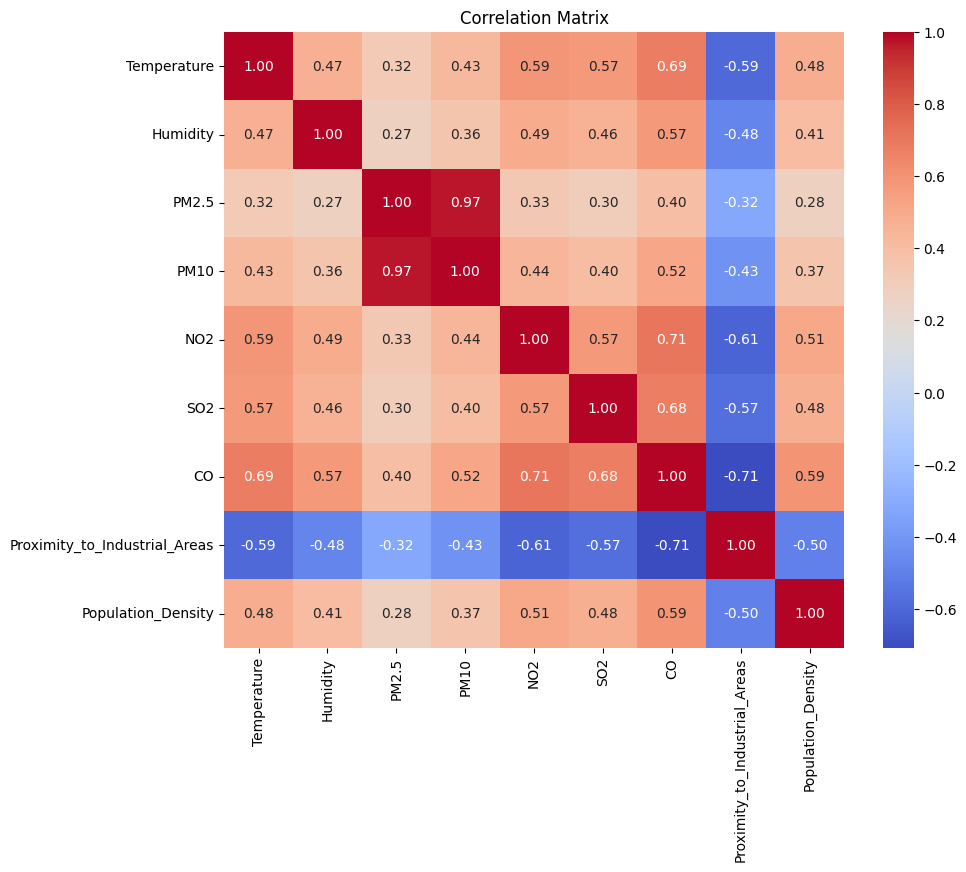

In [426]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

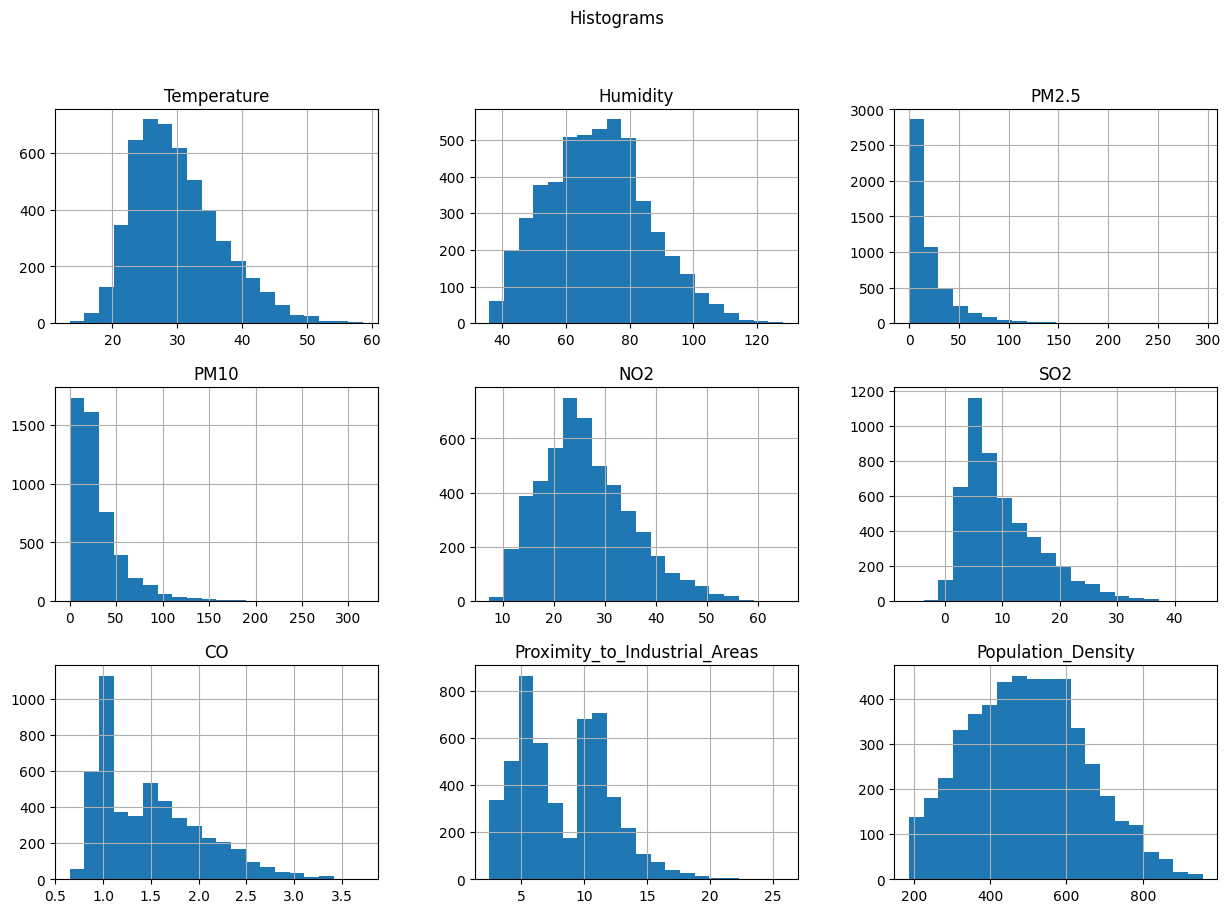

In [427]:
data.hist(bins=20, figsize=(15,10))
plt.suptitle("Histograms")
plt.show()

<ipython-input-428-974230f36021>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


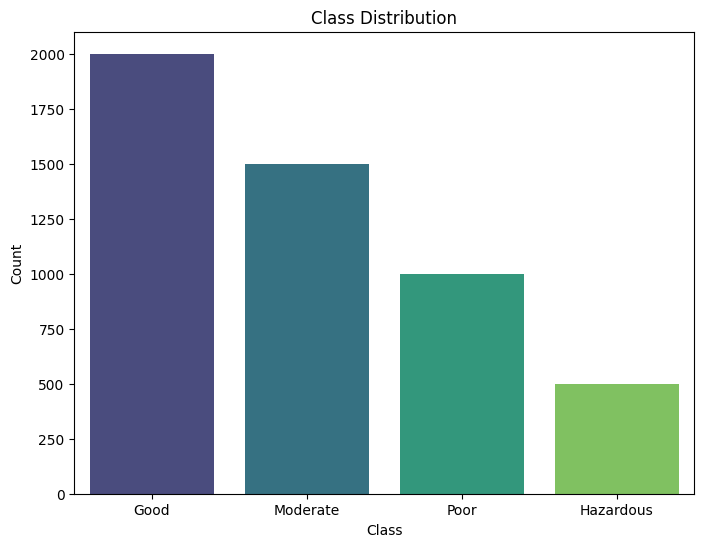

In [428]:
class_column = data.columns[-1]
class_counts = data[class_column].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [429]:
data['Air Quality'].value_counts()

,count
Air Quality,
Good,2000
Moderate,1500
Poor,1000
Hazardous,500


Проверка на пропущенные значения

In [430]:
data.isnull().sum()

,0
Temperature,0
Humidity,0
PM2.5,0
PM10,0
NO2,0
SO2,0
CO,0
Proximity_to_Industrial_Areas,0
Population_Density,0
Air Quality,0


In [431]:
from sklearn.metrics import euclidean_distances
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_fscore_support

**Анализ категориального признака "Air Quality"**

Преобразование категориального признака "Air Quality" в числовой формат

In [432]:
label_encoder = LabelEncoder()
data['Air Quality'] = label_encoder.fit_transform(data['Air Quality'])
data['Air Quality'].value_counts()

,count
Air Quality,
0,2000
2,1500
3,1000
1,500


Скалирование числовых данных

In [433]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(columns=['Air Quality']))

Среднее и стандартное отклонение после нормализации

In [434]:
scaled_mean_std = (scaled_data.mean(axis=0), scaled_data.std(axis=0))
scaled_mean_std

(array([-4.00746103e-16,  4.55457894e-16,  9.37916411e-17, -1.47437618e-16,
         1.33582034e-16, -7.24753590e-17, -3.34665629e-16,  5.25801624e-17,
        -1.87583282e-16]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1.]))

# Обучающая и тестовая выборки

In [435]:
X = scaled_data  # Нормализованные числовые данные
y = data['Air Quality']  # Целевой признак
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер тренировочной выборки: (4000, 9)
Размер тестовой выборки: (1000, 9)


# Метод K ближайших соседей, kNN

Ищем оптимальное k

In [436]:
k_values = range(1, 31)
cross_val_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')  # 5-кратная кросс-валидация
    cross_val_scores.append(scores.mean())
optimal_k = k_values[np.argmax(cross_val_scores)]

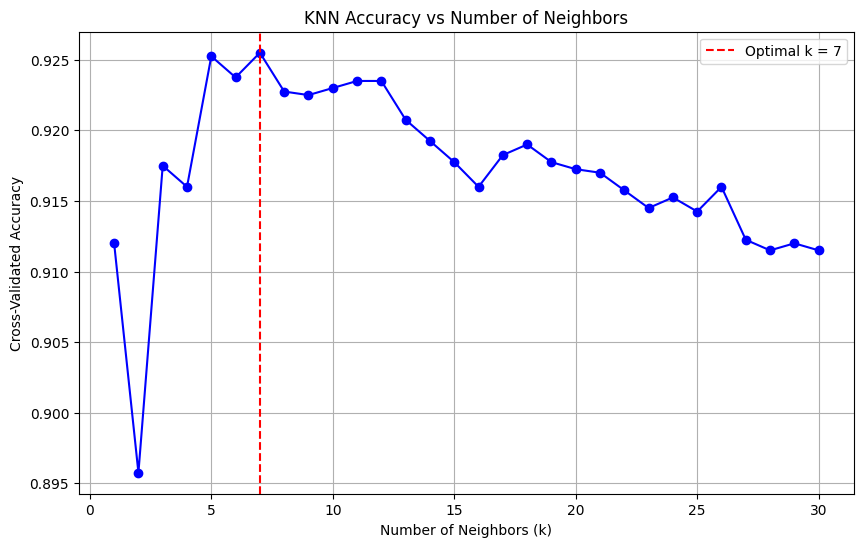

In [437]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, cross_val_scores, marker='o', linestyle='-', color='blue')
plt.axvline(optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title('KNN Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.show()

Обучение KNN с оптимальным k

In [438]:
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [439]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

Оценка точности

In [452]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.9415
Test Accuracy: 0.9230


In [441]:
classification_metrics = precision_recall_fscore_support(y_test, y_test_pred)
report_df = pd.DataFrame({
    "Class": label_encoder.classes_,
    "Precision": classification_metrics[0],
    "Recall": classification_metrics[1],
    "F1-Score": classification_metrics[2],
    "Support": classification_metrics[3]
})
report_df

,Class,Precision,Recall,F1-Score,Support
0,Good,0.985149,0.995000,0.990050,400
1,Hazardous,0.921053,0.700000,0.795455,100
2,Moderate,0.905956,0.963333,0.933764,300
3,Poor,0.825871,0.830000,0.827930,200


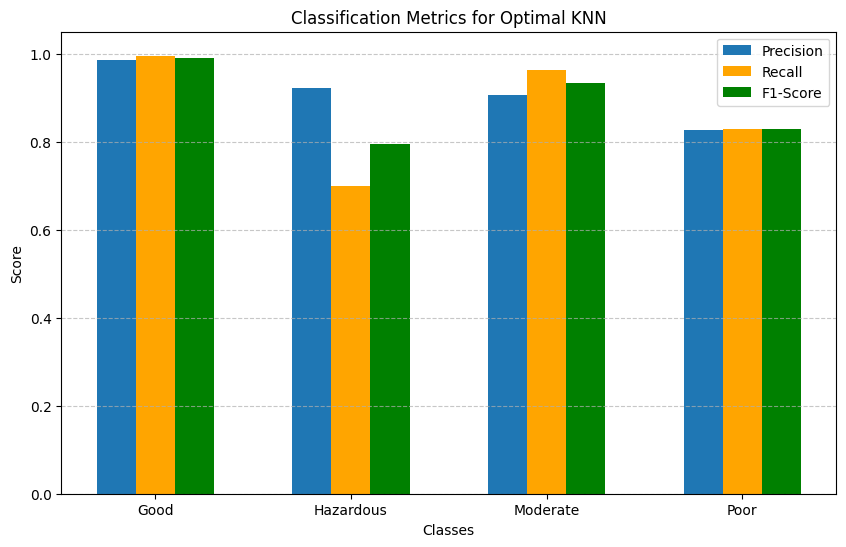

In [442]:
x = np.arange(len(label_encoder.classes_))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, classification_metrics[0], width=0.2, label='Precision')
plt.bar(x, classification_metrics[1], width=0.2, label='Recall', color='orange')
plt.bar(x + 0.2, classification_metrics[2], width=0.2, label='F1-Score', color='green')
plt.xticks(x, label_encoder.classes_)
plt.title('Classification Metrics for Optimal KNN')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **RandomForest**

In [443]:
from sklearn.ensemble import RandomForestClassifier

Поиск оптимального количества деревьев

In [444]:
n_estimators_range = range(10, 120, 5)
cross_val_scores_rf = []

for n in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')  # 5-кратная кросс-валидация
    cross_val_scores_rf.append(scores.mean())

optimal_trees = n_estimators_range[np.argmax(cross_val_scores_rf)]

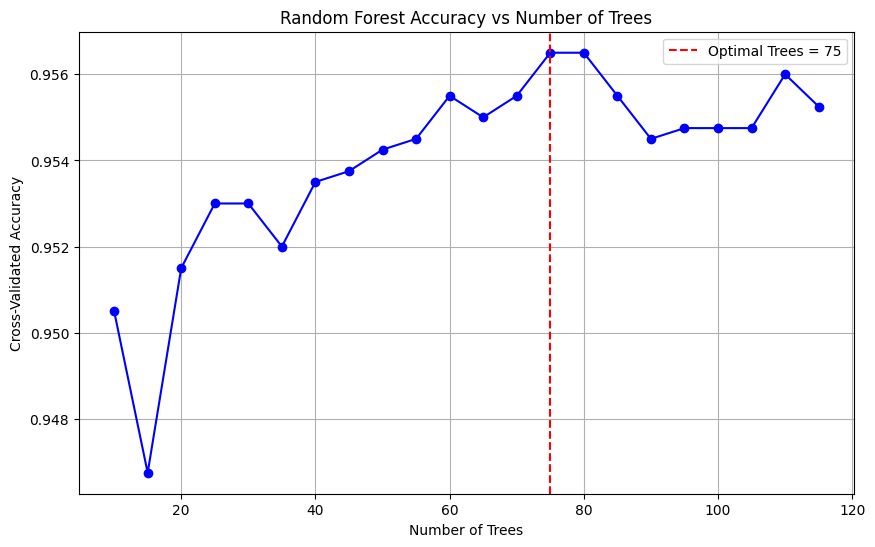

In [445]:
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, cross_val_scores_rf, marker='o', linestyle='-', color='blue')
plt.axvline(optimal_trees, color='red', linestyle='--', label=f'Optimal Trees = {optimal_trees}')
plt.title('Random Forest Accuracy vs Number of Trees')
plt.xlabel('Number of Trees')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.grid()
plt.show()

Обучение Random Forest с оптимальным количеством деревьев

In [446]:
rf_optimal = RandomForestClassifier(n_estimators=optimal_trees, random_state=42)
rf_optimal.fit(X_train, y_train)

RandomForestClassifier(n_estimators=75, random_state=42)

In [447]:
y_train_pred_rf = rf_optimal.predict(X_train)
y_test_pred_rf = rf_optimal.predict(X_test)

Оценка точности

In [451]:
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)

print(f"Train Accuracy: {train_accuracy_rf:.4f}")
print(f"Test Accuracy: {test_accuracy_rf:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9510


In [377]:
classification_metrics_rf = precision_recall_fscore_support(y_test, y_test_pred_rf)
report_rf_df = pd.DataFrame({
    "Class": label_encoder.classes_,
    "Precision": classification_metrics_rf[0],
    "Recall": classification_metrics_rf[1],
    "F1-Score": classification_metrics_rf[2],
    "Support": classification_metrics_rf[3]
})
report_rf_df

,Class,Precision,Recall,F1-Score,Support
0,Good,0.997506,1.000000,0.998752,400
1,Hazardous,0.888889,0.800000,0.842105,100
2,Moderate,0.969900,0.966667,0.968280,300
3,Poor,0.861905,0.905000,0.882927,200


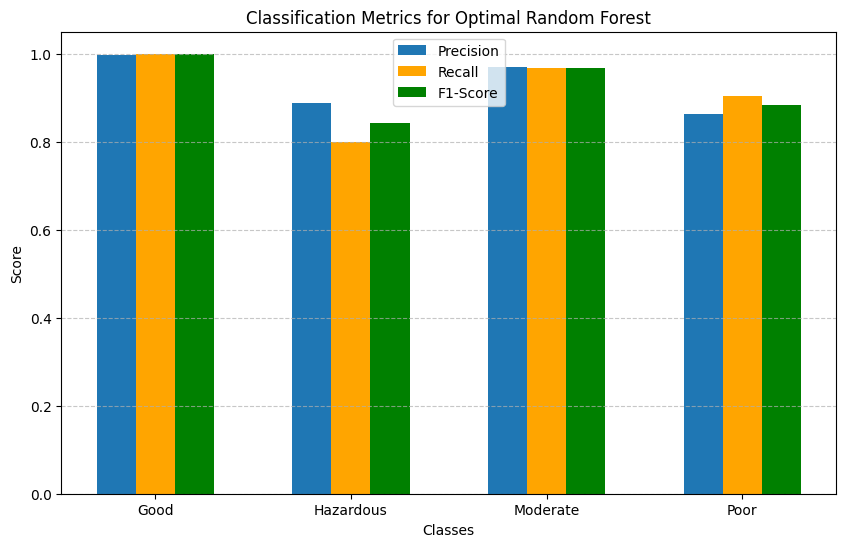

In [378]:
x = np.arange(len(label_encoder.classes_))
plt.figure(figsize=(10, 6))
plt.bar(x - 0.2, classification_metrics_rf[0], width=0.2, label='Precision')
plt.bar(x, classification_metrics_rf[1], width=0.2, label='Recall', color='orange')
plt.bar(x + 0.2, classification_metrics_rf[2], width=0.2, label='F1-Score', color='green')
plt.xticks(x, label_encoder.classes_)
plt.title('Classification Metrics for Optimal Random Forest')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# **Вывод**
**Предварительный анализ данных:**

*   Проведен анализ исходного датасета, включающий проверку пропущенных
значений, визуализацию распределений и расчет основных статистических характеристик.
*   Данные были успешно подготовлены для моделирования, включая нормализацию числовых признаков и кодирование категориальных переменных.

**Оптимизация параметров:**


*   Для KNN найдено оптимальное количество соседей (k) через кросс-валидацию, что позволило добиться максимальной точности модели.
*   Для KNN найдено оптимальное количество соседей (n_estimators_range) через кросс-валидацию, что позволило добиться максимальной точности модели.

**Результаты моделей:**

*   KNN:
  * Точность на обучающей выборке: 94.15%.
  * Точность на тестовой выборке: 92.3%.
*   Random Forest:
  * Точность на обучающей выборке: 100%.
  * Точность на тестовой выборке: 95.1%.

**Заключение:**

* Оба метода успешно справились с задачей классификации.
* Random Forest является предпочтительным методом в данном случае из-за лучшей общей точности





